In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, regexp_extract
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import DataFrame
from pyspark.ml.feature import MinMaxScaler

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
spark = SparkSession.builder.appName("lending-club").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/28 22:08:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Functions

In [4]:
def one_hot_encode_column(df, input_col):
    indexer = StringIndexer(inputCol=input_col, outputCol=input_col + '_indexed')
    indexed_df = indexer.fit(df).transform(df)

    encoder = OneHotEncoder(inputCol=input_col + '_indexed', outputCol=input_col + '_encoded')
    encoded_df = encoder.fit(indexed_df).transform(indexed_df)

    encoded_df = encoded_df.drop(input_col, input_col + '_indexed')

    return encoded_df

def scale_features(input_df: DataFrame, input_col: str, output_col: str) -> DataFrame:
    """
    Scale the specified feature column using Min-Max Scaling.

    Args:
        input_df (DataFrame): The input DataFrame.
        input_col (str): The name of the feature column to scale.
        output_col (str): The name of the output scaled feature column.

    Returns:
        DataFrame: The DataFrame with the scaled feature column.
    """
    scaler = MinMaxScaler(inputCol=input_col, outputCol=output_col)
    scaler_model = scaler.fit(input_df)
    scaled_df = scaler_model.transform(input_df)
    return scaled_df

def evaluate_model(model, model_name, train_data, validation_data, test_data):
    model = model.fit(train_data)

    predictions_train = model.transform(train_data)
    predictions_validation = model.transform(validation_data)
    predictions_test = model.transform(test_data)

    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
    f1_evaluator = MulticlassClassificationEvaluator(metricName="weightedFMeasure", labelCol="target")

    accuracy_train = evaluator_accuracy.evaluate(predictions_train)
    f1_score_train = f1_evaluator.evaluate(predictions_train)

    accuracy_validation = evaluator_accuracy.evaluate(predictions_validation)
    f1_score_validation = f1_evaluator.evaluate(predictions_validation)

    accuracy_test = evaluator_accuracy.evaluate(predictions_test)
    f1_score_test = f1_evaluator.evaluate(predictions_test)

    results_df = pd.DataFrame({
    "Model": [model_name],
    "Accuracy (Train)": [round(accuracy_train, 3)],
    "F1 Score (Train)": [round(f1_score_train, 3)],
    "Accuracy (Validation)": [round(accuracy_validation, 3)],
    "F1 Score (Validation)": [round(f1_score_validation, 3)],
    "Accuracy (Test)": [round(accuracy_test, 3)],
    "F1 Score (Test)": [round(f1_score_test, 3)],
    })

    return results_df

24/09/28 22:09:13 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


# Upload dataset

In [7]:
selected_columns = [
    "id",
    "purpose",
    "term",
    "verification_status",
    "acc_now_delinq",
    "addr_state",
    "annual_inc",
    "application_type",
    "dti",
    "grade",
    "home_ownership",
    "initial_list_status",
    "installment",
    "int_rate",
    "loan_amnt",
    "loan_status",
    'tax_liens',
    'delinq_amnt',
    'policy_code',
    'last_fico_range_high',
    'last_fico_range_low',
    'recoveries',
    'collection_recovery_fee'

]
df = spark.read.csv('data/accepted_2007_to_2018Q4.csv', header=True).select(selected_columns)
df.limit(5).toPandas()

,id,purpose,term,verification_status,acc_now_delinq,addr_state,annual_inc,application_type,dti,grade,...,int_rate,loan_amnt,loan_status,tax_liens,delinq_amnt,policy_code,last_fico_range_high,last_fico_range_low,recoveries,collection_recovery_fee
0,68407277,debt_consolidation,36 months,Not Verified,0.0,PA,55000.0,Individual,5.91,C,...,13.99,3600.0,Fully Paid,0.0,0.0,1.0,564.0,560.0,0.0,0.0
1,68355089,small_business,36 months,Not Verified,0.0,SD,65000.0,Individual,16.06,C,...,11.99,24700.0,Fully Paid,0.0,0.0,1.0,699.0,695.0,0.0,0.0
2,68341763,home_improvement,60 months,Not Verified,0.0,IL,63000.0,Joint App,10.78,B,...,10.78,20000.0,Fully Paid,0.0,0.0,1.0,704.0,700.0,0.0,0.0
3,66310712,debt_consolidation,60 months,Source Verified,0.0,NJ,110000.0,Individual,17.06,C,...,14.85,35000.0,Current,0.0,0.0,1.0,679.0,675.0,0.0,0.0
4,68476807,major_purchase,60 months,Source Verified,0.0,PA,104433.0,Individual,25.37,F,...,22.45,10400.0,Fully Paid,0.0,0.0,1.0,704.0,700.0,0.0,0.0


## **EDA**

# Missing Values

In [8]:
null_counts = df.agg(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+---+-------+----+-------------------+--------------+----------+----------+----------------+----+-----+--------------+-------------------+-----------+--------+---------+-----------+---------+-----------+-----------+--------------------+-------------------+----------+-----------------------+
| id|purpose|term|verification_status|acc_now_delinq|addr_state|annual_inc|application_type| dti|grade|home_ownership|initial_list_status|installment|int_rate|loan_amnt|loan_status|tax_liens|delinq_amnt|policy_code|last_fico_range_high|last_fico_range_low|recoveries|collection_recovery_fee|
+---+-------+----+-------------------+--------------+----------+----------+----------------+----+-----+--------------+-------------------+-----------+--------+---------+-----------+---------+-----------+-----------+--------------------+-------------------+----------+-----------------------+
|  0|     34|  33|                 33|           221|        34|        37|              88|1745|   33|            33|      

In [9]:
df = df.na.drop()

# 'purpose'

In [10]:
df_with_count = df.groupBy('purpose').count()
df_with_count.show()

+------------------+-------+
|           purpose|  count|
+------------------+-------+
|           wedding|   2351|
|             other| 139270|
|    small_business|  24638|
|debt_consolidation|1276774|
|       credit_card| 516570|
|            moving|  15369|
|          vacation|  15518|
|  renewable_energy|   1444|
|             house|  14119|
|               car|  23996|
|    major_purchase|  50400|
|           medical|  27453|
|  home_improvement| 150290|
|       educational|    404|
+------------------+-------+



In [11]:
# Replacing values in the 'purpose' column based on the 'count' column condition
# If 'count' is less than 300, set 'purpose' to "other", else keep the original 'purpose'

df = df\
.join(df_with_count, on='purpose', how='left')\
.withColumn("purpose", when(col("count") < 300, "other").otherwise(col("purpose")))\
.drop('count')

In [12]:
unique_purposes = df.select("purpose").distinct()
unique_purposes.show()

+------------------+
|           purpose|
+------------------+
|           wedding|
|       educational|
|             other|
|    small_business|
|debt_consolidation|
|       credit_card|
|            moving|
|          vacation|
|  renewable_energy|
|             house|
|               car|
|    major_purchase|
|           medical|
|  home_improvement|
+------------------+



# 'term'

In [13]:
df.groupby('term').count()\
.show()

+----------+-------+
|      term|  count|
+----------+-------+
| 36 months|1608405|
| 60 months| 650191|
+----------+-------+



In [14]:
# Applying a regular expression to extract numbers from the 'term' column and then casting it to the Integer data type.

df = df\
.withColumn("term", regexp_extract(col("term"), r'(\d+)', 0).cast("int"))

In [15]:
df.groupby('verification_status').count()\
.show()

+-------------------+------+
|verification_status| count|
+-------------------+------+
|           Verified|629395|
|    Source Verified|886141|
|       Not Verified|743060|
+-------------------+------+



In [16]:
# Encode 'verification_status' column values into a new column 'verification_status_encoded'
# If 'verification_status' is either "Verified" or "Source Verified", set 'verification_status_encoded' to 0
# Otherwise, set it to 1

df = df\
.withColumn("verification_status_encoded",
            when(col("verification_status")
                 .isin(["Verified", "Source Verified"]),0)
            .otherwise(1))\
.drop("verification_status")

In [17]:
df.groupby('verification_status_encoded').count()\
.show()

+---------------------------+-------+
|verification_status_encoded|  count|
+---------------------------+-------+
|                          1| 743060|
|                          0|1515536|
+---------------------------+-------+



# 'acc_now_delinq'

In [18]:
df.groupby('acc_now_delinq').count()\
.show()

+--------------+-------+
|acc_now_delinq|  count|
+--------------+-------+
|           1.0|   8290|
|           0.0|2249817|
|           5.0|      3|
|           4.0|     11|
|           2.0|    421|
|           3.0|     50|
|          14.0|      1|
|           6.0|      2|
|           7.0|      1|
+--------------+-------+



In [19]:
# Define the valid values for 'acc_now_delinq'
valid_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Modify the 'acc_now_delinq' column:
# 1. Cast the column to IntegerType
# 2. Set values greater than or equal to 4 to 4, and keep other valid values as they are
df = df.withColumn('acc_now_delinq', col('acc_now_delinq').cast('int')) \
       .withColumn('acc_now_delinq', when(col('acc_now_delinq') >= 4, 4).otherwise(col('acc_now_delinq'))) \
       .filter(col('acc_now_delinq').isin(valid_values))

In [20]:
df.groupby('acc_now_delinq').count()\
.show()

+--------------+-------+
|acc_now_delinq|  count|
+--------------+-------+
|             1|   8290|
|             3|     50|
|             4|     18|
|             2|    421|
|             0|2249817|
+--------------+-------+



# 'application_type'

In [21]:
df.groupby('application_type').count()\
.show()

+----------------+-------+
|application_type|  count|
+----------------+-------+
|       Joint App| 118999|
|      Individual|2139597|
+----------------+-------+



In [22]:
# Define the valid values for 'application_type'
valid_values = ['Joint App', 'Individual']

# Modify the 'application_type' column:
# 1. Map 'Joint App' to 0 and 'Individual' to 1
# 2. Remove other values
# 3. Cast the column to IntegerType

df = df.withColumn('application_type',
                   when(col('application_type') == 'Joint App', 0)
                   .when(col('application_type') == 'Individual', 1)
                   .otherwise(None))

df = df.filter(col('application_type').isNotNull()).withColumn('application_type', col('application_type').cast('int'))

# 'grade'

In [23]:
df.groupby('grade').count()\
.show()

+-----+------+
|grade| count|
+-----+------+
|    F| 41758|
|    E|135506|
|    B|663013|
|    D|324042|
|    C|649471|
|    A|432662|
|    G| 12144|
+-----+------+



In [24]:
# Create a StringIndexer to convert 'grade' column into numerical indices
grade_indexer = StringIndexer(inputCol="grade", outputCol="grade_index", stringOrderType="alphabetAsc")

df = grade_indexer\
.fit(df)\
.transform(df)\
.drop('grade')

In [23]:
df.groupby('grade_index').count()\
.show()

+-----------+------+
|grade_index| count|
+-----------+------+
|        0.0|432662|
|        1.0|663013|
|        4.0|135506|
|        3.0|324042|
|        2.0|649471|
|        6.0| 12144|
|        5.0| 41758|
+-----------+------+



# One Hot Encoder

In [25]:
columns_to_encode = ['purpose', 'addr_state', 'home_ownership', 'initial_list_status']

for column in columns_to_encode:
    df = one_hot_encode_column(df, column)

# Cast to float type

In [26]:
columns_to_cast = [ 'installment',
                   'int_rate',
                    'loan_amnt',
                    'annual_inc',
                    'dti',
                    'tax_liens',
                    'delinq_amnt',
                    'policy_code',
                    'last_fico_range_high',
                    'last_fico_range_low',
                    'recoveries',
                    'collection_recovery_fee'
]

# cast to float
for column_name in columns_to_cast:
    df = df.withColumn(column_name, col(column_name).cast('float'))

In [27]:
df.dtypes

[('id', 'string'),
 ('term', 'int'),
 ('acc_now_delinq', 'int'),
 ('annual_inc', 'float'),
 ('application_type', 'int'),
 ('dti', 'float'),
 ('installment', 'float'),
 ('int_rate', 'float'),
 ('loan_amnt', 'float'),
 ('loan_status', 'string'),
 ('tax_liens', 'float'),
 ('delinq_amnt', 'float'),
 ('policy_code', 'float'),
 ('last_fico_range_high', 'float'),
 ('last_fico_range_low', 'float'),
 ('recoveries', 'float'),
 ('collection_recovery_fee', 'float'),
 ('verification_status_encoded', 'int'),
 ('grade_index', 'double'),
 ('purpose_encoded', 'vector'),
 ('addr_state_encoded', 'vector'),
 ('home_ownership_encoded', 'vector'),
 ('initial_list_status_encoded', 'vector')]

# 'loan_status' -> target

In [28]:
df.groupby('loan_status').count()\
.show()

+--------------------+-------+
|         loan_status|  count|
+--------------------+-------+
|          Fully Paid|1076218|
|             Default|     40|
|     In Grace Period|   8427|
|         Charged Off| 268452|
|  Late (31-120 days)|  21443|
|             Current| 877018|
|   Late (16-30 days)|   4344|
|Does not meet the...|   1913|
|Does not meet the...|    741|
+--------------------+-------+



In [29]:
# encode 'loan_status' to 0 - fully paid, 1 - late, 2 - charged off
df = df.withColumn("target",
                   when(col("loan_status") == "Fully Paid", 0)
                   .when((col("loan_status") == "Late (16-30 days)") | (col("loan_status") == "Late (31-120 days)") | (col("loan_status") == "In Grace Period"), 1)
                   .when((col("loan_status") == "Charged Off") | (col("loan_status") == 'Default'), 2)
                   .otherwise(None))\
.drop("loan_status")
df = df.filter(df.target.isNotNull())

In [30]:
df.groupby('target').count()\
.show()

+------+-------+
|target|  count|
+------+-------+
|     1|  34214|
|     2| 268492|
|     0|1076218|
+------+-------+



# Downsampling

In [31]:
df = df.drop('id')
df_downsampled = df.filter(col("target") == 0).sampleBy("target", fractions={0: 0.3}).unionAll(df.filter(col("target") != 0))
df_downsampled = df_downsampled.na.drop()

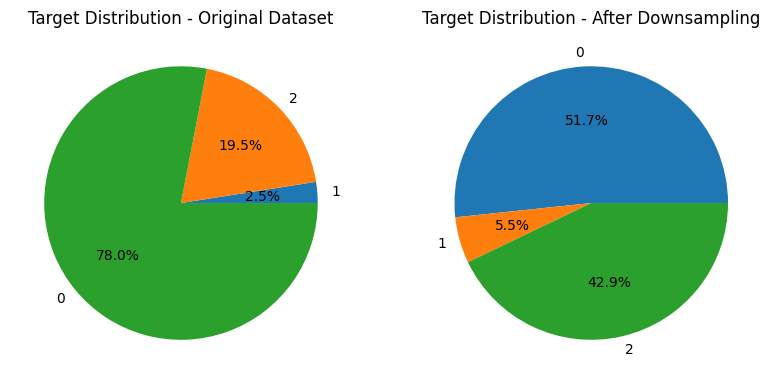

In [32]:
loan_status_count_original = df.groupby('target').count().toPandas()

plt.figure(figsize=(15, 6))

# Subplot 1 - Target Distribution before downsampling
plt.subplot(1, 3, 1)
plt.pie(loan_status_count_original['count'], labels=loan_status_count_original['target'], autopct='%1.1f%%')
plt.title('Target Distribution - Original Dataset')

# Downsampled dataset
loan_status_count_downsampled = df_downsampled.groupby('target').count().toPandas()

# Subplot 2 - Target Distribution after downsampling
plt.subplot(1, 3, 2)
plt.pie(loan_status_count_downsampled['count'], labels=loan_status_count_downsampled['target'], autopct='%1.1f%%')
plt.title('Target Distribution - After Downsampling')

plt.show()

# VectorAssembler

In [34]:
all_columns = df_downsampled.columns
feature_cols = [col_name for col_name in all_columns if col_name != 'target']
print(feature_cols)

target = ['target']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_to_scale")

df_downsampled = assembler.transform(df_downsampled)

df_downsampled\
.select('features_to_scale', 'target')\
.show(5)

['term', 'acc_now_delinq', 'annual_inc', 'application_type', 'dti', 'installment', 'int_rate', 'loan_amnt', 'tax_liens', 'delinq_amnt', 'policy_code', 'last_fico_range_high', 'last_fico_range_low', 'recoveries', 'collection_recovery_fee', 'verification_status_encoded', 'grade_index', 'purpose_encoded', 'addr_state_encoded', 'home_ownership_encoded', 'initial_list_status_encoded', 'features_to_scale']


IllegalArgumentException: Output column features_to_scale already exists.

# MinMaxScaler

In [33]:
train_data, temp_data = df_downsampled.randomSplit([0.8, 0.2], seed=42)
test_data, val_data = temp_data.randomSplit([0.5, 0.5], seed=42)

In [34]:
train_data = scale_features(train_data, "features_to_scale", "features")
val_data = scale_features(val_data, "features_to_scale", "features")
test_data = scale_features(test_data, "features_to_scale", "features")

# Models

In [35]:
lr = LogisticRegression(featuresCol='features', labelCol='target')
results_df_lr = evaluate_model(lr, 'LogisticRegression', train_data, val_data, test_data)

24/09/21 13:38:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [36]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'target')
results_df_rf = evaluate_model(rf, 'Random Forest', train_data, val_data, test_data)

In [37]:
layers = [86, 64, 32, 3]
mlp = MultilayerPerceptronClassifier(layers=layers, labelCol="target", featuresCol="features", maxIter=100, seed=123)
results_df_mlp = evaluate_model(mlp, 'Neural Network', train_data, val_data, test_data)

In [38]:
final_results_df = pd.concat([results_df_lr, results_df_rf, results_df_mlp], ignore_index=True)
final_results_df

,Model,Accuracy (Train),F1 Score (Train),Accuracy (Validation),F1 Score (Validation),Accuracy (Test),F1 Score (Test)
0,LogisticRegression,0.881,0.863,0.880,0.860,0.882,0.863
1,Random Forest,0.876,0.852,0.875,0.850,0.877,0.853
2,Neural Network,0.862,0.841,0.863,0.841,0.864,0.843
